In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  MultinomialNB, GaussianNB, BernoulliNB

kNN = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier() #using gini for the feature selection
regressor = LogisticRegression(solver='lbfgs',max_iter=100)
mnb = MultinomialNB()
gnb = GaussianNB
bnb = BernoulliNB
models = [kNN, tree, regressor, mnb]

In [ ]:
bcDB = datasets.load_breast_cancer()
bcDF = pd.DataFrame(data= bcDB.data, columns=list(bcDB["feature_names"]))
bcDF['target'] = pd.Series(bcDB.target)
bcDF = bcDF.reset_index(drop=True)
vc = bcDF['target'].value_counts()
for i,j in enumerate(bcDB.target_names):
    print(i, vc[i], j)
y = bcDF.pop('target').values
X = bcDF.values

print("Malignant in original data set is: %0.2f" %((1 - (y.sum()/len(y))) *100),"percent")

#### Original DataSet attributes:

--> 212 malignant and 357 benign.

--> Malignant in original data set is: 37.26 percent.

--> Malignant in Test Set is : 35.11 percent.

In [ ]:
#-------------------------------------Hold out testing---------------------------------------------#

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=5, test_size = 0.33)
malig_test = 100 * ( 1 -  (y_test.sum()/len(y_test)))
print("Test Set Malignant Percentage: %0.2f\n" %(malig_test) )
models = [mnb,kNN,tree, regressor]
malign = {}
for m in models:
    y_pred  = m.fit(X_train, y_train).predict(X_test)
    malig = 100 * ( 1 -  (y_pred.sum()/len(y_pred)))
    malign.update({type(m).__name__ : malig})
    accuracy = accuracy_score(y_test,y_pred)
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    fp_rate = fp.sum() / (fp.sum() + tn.sum())
    tp_rate = tp.sum() / (tp.sum() + fn.sum())
    fn_rate = fn.sum() / (fn.sum() + tp.sum()) 
    print("Model {}: ".format(type(m).__name__))
    print("Malignant Percentage: %0.2f" %(malig) )
    print("Accuracy: {:.2f}".format(accuracy))
    print("FP: {:.2f} and  TP: {:.2f}\n".format(fp_rate, tp_rate))

#### Our Objective is to have a low FP rate and a high TP rate.
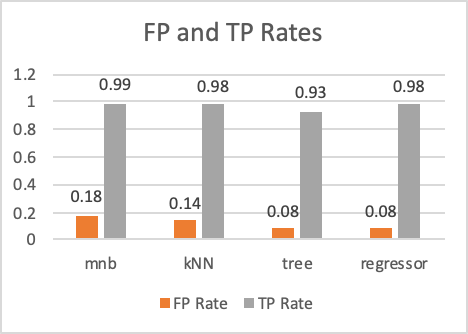

#### Malignant Class predction results
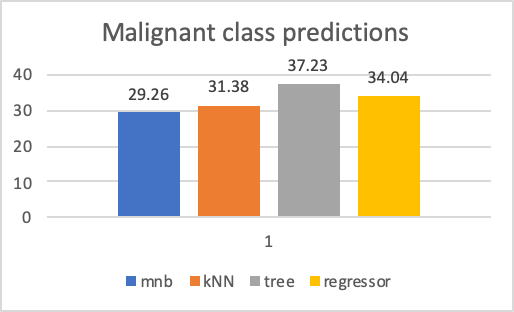

#### Notes:

1.It has been  well researched and documented that Accuracy is not a reliable measure to evaluate the classification models. Hence, here I have not used accuracy to compare these models

2.Malignant class percentage in test data set is around ~35%, all the models except Decision Tree have picked up this under-representation and accentuated it. Decision tree does a better job here.

3.Naive_Bayes has a strong bias towards the majority class (both FP and TP rate high).

4.We can say that Logistic Regression and DT performs better in this case, if we take False psitive and True Positive rates along with the Malignant class predictions.

5.kNN also has a high false positive rate, which is not desirable.

--> Results from Decision tree vary, each time by a bit, each time we run our code.!

In [ ]:
#------------------------------Using Cross Validate to check the bias---------------------------------
from sklearn.model_selection import cross_validate
from sklearn.metrics import  make_scorer

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]

scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

models = [mnb,kNN,tree, regressor]
folds = 4
v = 0
for m in models:
    cv_results = cross_validate(m, X, y, cv=folds, scoring=scoring, return_train_score=False,verbose=v, n_jobs=-1)
    fp_rate = cv_results['test_fp'].sum() / (cv_results['test_fp'].sum() + cv_results['test_tn'].sum())
    tp_rate = cv_results['test_tp'].sum() / (cv_results['test_tp'].sum() + cv_results['test_fn'].sum())
    print("{} x CV {:22} FP: {:.2f}  TP: {:.2f}".format(folds, type(m).__name__, fp_rate, tp_rate))

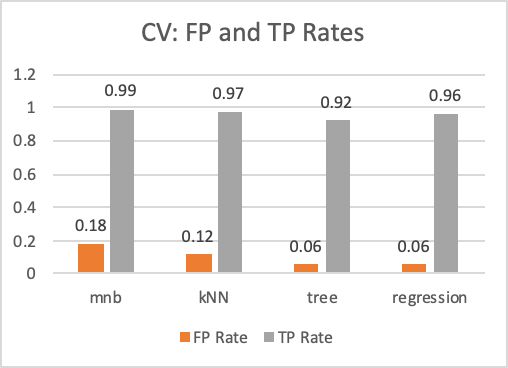

### Notes from CV:

1.Similar results as achieved from Hold-Out testing.

2.Naive Bayes has a strong positive class bias again!(Similar results from the Hold out testing), followed by kNN. 

3.Decision Tree and Logistic Regression fare better.

#------------------------------------------------------------------------------#
### SMOTE - synthesises new minority instances between existing (real) minority instances.

I have used SMOTE to overcame the bias on training data.

Before OverSampling, counts of label '1': 235 and label '0': 146.

After OverSampling,  counts of label '1': 235 and label '0': 235.

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#X_train_res,X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=5,test_size=0.5)

print("Before OverSampling, counts of label '1': {}".format(y_train.sum()))
print("Before OverSampling, counts of label '0': {} \n".format(len(y_train) - y_train.sum()))

models = [mnb,kNN,tree, regressor]
for m in models:
    y_pred_res  = m.fit(X_train_res, y_train_res).predict(X_test)
    malig_res =  100 * (1 -  (y_pred_res.sum()/len(y_pred_res)))
 
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred_res).ravel()
    fp_rate = fp.sum() / (fp.sum() + tn.sum())
    tp_rate = tp.sum() / (tp.sum() + fn.sum())
    
    print("Malignant class prediction from model {} is {:.2f}".format(type(m).__name__, malig_res))
    print("From {:22} FP: {:.2f}  TP: {:.2f}\n".format(type(m).__name__, fp_rate, tp_rate))
    

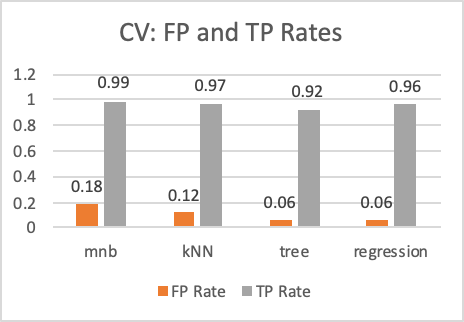

### Results from SMOTE:

1.If we take FP rate into account, except Naive_Bayes which still has a positive class bias,we can say that there is a bit imporvement in the performance after applying SMOTE. Hwoever, results are not significant. 

2.Overall there is a increase in the predicted percentage of malignant class, which is not good if our model has a high false negative rate, although in this scenarion we have reasonably better results.

3.No huge improvement, this is a really small dataset with farily reasonable minority class presence, Hence, even before applying SMOTE our classifiers were doing a OK job. Hence, in the second data-set, I have used a data-set that has extereme high amount of bias.


### SECOND DATA SET:

For the Second data-set, I have taken a real-life fraud detection data(this is also sythetically dereived, Source - Kaggle dataset), here majority of the class is 0(Not Fraud transaction) and minority is 1(fraud transaction). It has proportionally extreme bias towards themajority class.  

In this case we will use False negative rate and True Negative rates to test the models, as here 0 is the majority class. Logically we must be concerned to reduce the trasactions that are False negative!! As trasactions which are being, false positive(i.e. falsly classified as a fraud transaction) can be easily sorted with some additional checks.
Objective --> Hence, we should need a low False Negative and High True Negative rates.

Note- This is a extreme biased data-set, close to real situation if we take fraudulent transaction, with Majority label - 587443 and Minority lables - 7200.

In [ ]:
fraud =  pd.read_csv("fraud.csv")

#---------------------Preprocessing, converting categorical attributes------------------------
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
fraud['gender'] = le.fit_transform(fraud['gender'])
fraud['category'] = le.fit_transform(fraud['category'])
fraud['customer'] = fraud['customer'].str[2:-1]
fraud['merchant'] = fraud['merchant'].str[2:-1]
fraud['age'] = le.fit_transform(fraud['age'])
fraud['zip'] = fraud['zip'].str[1:-1]

y = fraud.pop("fraud").values
X = fraud.values


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=123)

print(y.sum(), len(y) - y.sum())

In [ ]:
#-------------------------------------Hold Out Testing-------------------------------------------------
models = [mnb,kNN,tree, regressor]
for m in models:
    y_pred  = m.fit(X_train, y_train).predict(X_test)
    positive = 100 * (y_pred.sum()/len(y_pred))
    negative = 100 * (1- (y_pred.sum()/len(y_pred)))
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    tn_rate = tn.sum() / (tn.sum() + fp.sum())
    fn_rate = fn.sum() / (tp.sum() + fn.sum())
    print("{}:".format(type(m).__name__))
    print("Minority class[1] is {:.2f}% and Majority class[0] is {:.2f}%  ".format(positive,negative))
    print("FN: {:.2f}  TN: {:.2f}\n".format(fn_rate, tn_rate))

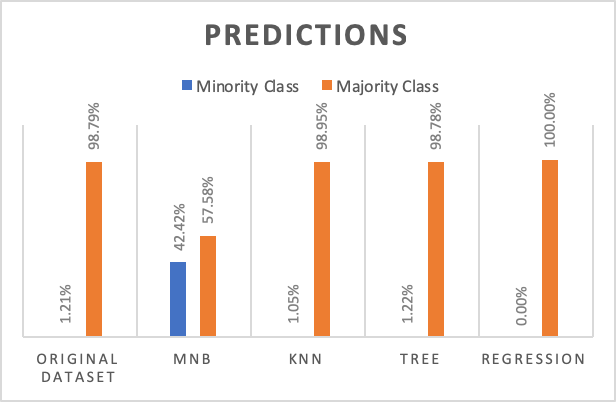

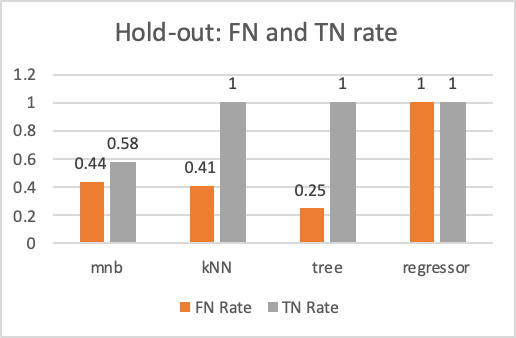

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(y_train.sum()))
print("Before OverSampling, counts of label '0': {} \n".format(len(y_train) - y_train.sum()))

#----------------------------Cross Validation-----------------------------------------------------
from sklearn.model_selection import cross_validate
from sklearn.metrics import  make_scorer

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]

scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

models = [mnb,kNN,tree, regressor]
folds = 4
v = 0
for m in models:
    cv_results = cross_validate(m, X, y, cv=folds, scoring=scoring, return_train_score=False,verbose=v, n_jobs=-1)
    tn_rate = cv_results['test_tn'].sum() / (cv_results['test_fp'].sum() + cv_results['test_tn'].sum())
    fn_rate = cv_results['test_fn'].sum() / (cv_results['test_tp'].sum() + cv_results['test_fn'].sum())
    print("{} x CV {:22} FN: {:.2f}  TN: {:.2f}".format(folds, type(m).__name__, fn_rate, tn_rate))

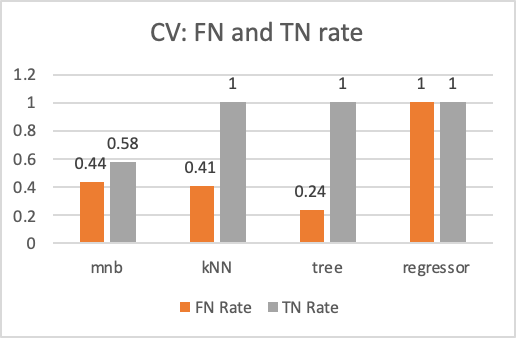

### NOTE:

1.To say the least results from Hold-out and Cross Validation testing are intersting.

2.Only model that makes reasonable predicitons is Decision tree, followed by kNN.

3.For Naive Bayes and Logisitic regression results are POOR, for regression, FN rate is 1.00 and minority class predciton is 0%!, Naive Bayes has a low TN rate as well as high FN rate.

In [ ]:
#---------------------------------Applying SMOTE--------------------------------------------------
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(y_train_res.sum()))
print("After OverSampling, counts of label '0': {} \n".format(len(y_train_res) - y_train_res.sum()))

In [ ]:
models = [mnb,kNN,tree, regressor]
for m in models:
    y_pred_res  = m.fit(X_train_res, y_train_res).predict(X_test)
    positive = 100 * (y_pred_res.sum()/len(y_pred_res))
    negative = 100 * ( 1- (y_pred_res.sum()/len(y_pred_res)))
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred_res).ravel()
    tn_rate = tn.sum() / (fp.sum() + tn.sum())
    fn_rate = fn.sum() / (tp.sum() + fn.sum())
    cm = confusion_matrix(y_test, y_pred_res)
    print("{}:".format(type(m).__name__))
    print("Minority class[1] is {:.2f}% and Majority class[0] is {:.2f}% ".format(positive,negative))
    print("Hold-Out testing FN: {:.2f}  TN: {:.2f}\n".format(fn_rate, tn_rate))

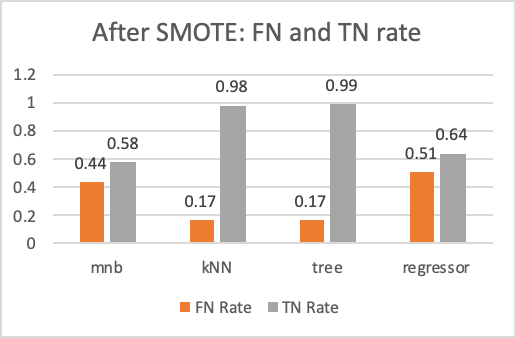

### Results and Conclusion drawn:

1.Improvement: Except Bayesian all models have improvements in lowering their false negative rates, specially for kNN which now fares as good as Decision tree classifier. Although, There is a trade-off, for kNN, DT and LR True Negative rate has decreased. However, kNN and DT predictions after SMOTE are still better than before, as our objective was to have a low FN rate and high TN rate.

2.Effective: Results indicate that is not a highly effective or a concrete strategy, offcourse there are some improvements but there are trade-offs too(decrease in TN rate), However, given a chocie we would have used the kNN or Decision Tree after SMOTE for the second dataset as they are closer to our listed objective.


3.Conclusions:This is a really complex propblem with no definite and concrete solutions,And each real problem would need a different strategy depending on its problem specifications.
